In [1]:
import os
import sys
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

sys.path.append('..')
from semilearn.core.utils import get_net_builder, get_dataset, over_write_args_from_file
from semilearn.algorithms.openmatch.openmatch import OpenMatchNet
from semilearn.algorithms.iomatch.iomatch import IOMatchNet

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--c', type=str, default='')

def load_model_at(step='best'):
    args.step = step
    if step == 'best':
        args.load_path = '/'.join(args.load_path.split('/')[1:-1]) + "/model_best.pth"
    if step == 'latest':
        #args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/model_at_{args.step}_step.pth"
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/latest_model.pth"
    else:
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/"+str(step)+"_model.pth"
        
    print(args.load_path)
    checkpoint_path = os.path.join(args.load_path)
    checkpoint = torch.load(checkpoint_path)
    load_model = checkpoint['ema_model']
    load_state_dict = {}
    for key, item in load_model.items():
        if key.startswith('module'):
            new_key = '.'.join(key.split('.')[1:])
            load_state_dict[new_key] = item
        else:
            load_state_dict[key] = item
    save_dir = '/'.join(checkpoint_path.split('/')[:-1])
    if step == 'best':
        args.save_dir = os.path.join(save_dir, f"model_best")
    else:
        args.save_dir = os.path.join(save_dir, f"step_{args.step}")
    os.makedirs(args.save_dir, exist_ok=True)
    _net_builder = get_net_builder(args.net, args.net_from_name)
    net = _net_builder(num_classes=args.num_classes)
    if args.algorithm == 'openmatch':
        net = OpenMatchNet(net, args.num_classes)
    elif args.algorithm == 'iomatch':
        net = IOMatchNet(net, args.num_classes)
    else:
        raise NotImplementedError
    keys = net.load_state_dict(load_state_dict)
    print(f'Model at step {args.step} loaded!')
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    return net

In [3]:
def evaluate_open(net, dataset_dict, num_classes, extended_test=False):
    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    y_pred_closed_list = []
    y_pred_ova_list = []
    
    results = {}
    
    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']

            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()

            num_batch = y.shape[0]
            total_num += num_batch
            
            out = net(x)
            logits, logits_open = out['logits'], out['logits_open']    
            pred_closed = logits.data.max(1)[1]
            
            probs = F.softmax(logits, 1)
            probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
            unk_score = probs_open[tmp_range, 0, pred_closed]
            pred_open = pred_closed.clone()
            pred_open[unk_score > 0.5] = num_classes

            y_true_list.extend(y.cpu().tolist())
            y_pred_closed_list.extend(pred_closed.cpu().tolist())
            y_pred_ova_list.extend(pred_open.cpu().tolist())

    y_true = np.array(y_true_list)

    closed_mask = y_true < num_classes
    open_mask = y_true >= num_classes
    y_true[open_mask] = num_classes

    y_pred_closed = np.array(y_pred_closed_list)
    y_pred_ova = np.array(y_pred_ova_list)

    # Closed Accuracy on Closed Test Data
    y_true_closed = y_true[closed_mask]
    y_pred_closed = y_pred_closed[closed_mask]
    closed_acc = accuracy_score(y_true_closed, y_pred_closed)
    closed_cfmat = confusion_matrix(y_true_closed, y_pred_closed, normalize='true')
    results['c_acc_c_p'] = closed_acc
    results['c_cfmat_c_p'] = closed_cfmat  

    # Open Accuracy on Full Test Data
    open_acc = balanced_accuracy_score(y_true, y_pred_ova)
    open_cfmat = confusion_matrix(y_true, y_pred_ova)
    results['o_acc_f_hq'] = open_acc  
    results['o_cfmat_f_hq'] = open_cfmat
        
    if extended_test:
        with torch.no_grad():
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()

                num_batch = y.shape[0]
                total_num += num_batch

                out = net(x)
                logits, logits_open = out['logits'], out['logits_open']    
                pred_closed = logits.data.max(1)[1]

                probs = F.softmax(logits, 1)
                probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
                unk_score = probs_open[tmp_range, 0, pred_closed]
                pred_open = pred_closed.clone()
                pred_open[unk_score > 0.5] = num_classes

                y_true_list.extend(y.cpu().tolist())
                y_pred_closed_list.extend(pred_closed.cpu().tolist())
                y_pred_ova_list.extend(pred_open.cpu().tolist())
            
        y_true = np.array(y_true_list)

        open_mask = y_true >= num_classes
        y_true[open_mask] = num_classes
        y_pred_ova = np.array(y_pred_ova_list)
        
        # Open Accuracy on Extended Test Data
        open_acc = balanced_accuracy_score(y_true, y_pred_ova)
        open_cfmat = confusion_matrix(y_true, y_pred_ova, normalize='true')
        results['o_acc_e_hq'] = open_acc  
        results['o_cfmat_e_hq'] = open_cfmat
    
    print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data: {results['c_acc_c_p'] * 100:.2f}\n"
              f" Open Accuracy on Full Test Data:     {results['o_acc_f_hq'] * 100:.2f}\n"
              #f" Open Accuracy on Extended Test Data: {results['o_acc_e_hq'] * 100:.2f}\n"
              f"#############################################################\n"
        )
    
    return results

In [4]:
def evaluate_io(args, net, dataset_dict, extended_test=False):
    """
    evaluation function for open-set SSL setting
    """

    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    p_list = []
    pred_p_list = []
    pred_hat_q_list = []
    pred_q_list = []
    pred_q_prob_list=[]
    pred_hat_p_list = []
    feat_proj_list= []
    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']
            print('y',len(y),y)
            
            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()
            y_true_list.extend(y.cpu().tolist())

            num_batch = y.shape[0]
            total_num += num_batch

            outputs = net(x)
            logits = outputs['logits']
            logits_mb = outputs['logits_mb']
            logits_open = outputs['logits_open']
            feat_proj= outputs['feat_proj']

            # predictions p of closed-set classifier
            p = F.softmax(logits, 1)
            pred_p = p.data.max(1)[1]
            pred_p_list.extend(pred_p.cpu().tolist())
            feat_proj_list.extend(feat_proj.cpu().tolist())
            
            # predictions hat_q from (closed-set + multi-binary) classifiers
            r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
            hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
            o_neg = r[tmp_range, 0, :]
            o_pos = r[tmp_range, 1, :]
            hat_q[:, :args.num_classes] = p * o_pos
            hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
            pred_hat_q = hat_q.data.max(1)[1]
            pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

            # predictions q of open-set classifier
            q = F.softmax(logits_open, 1)
            pred_q = q.data.max(1)[1]
            print('p',p[0],'o_pos',o_pos[0])
            print('q.data',q.data[0:10])
            print('hatq.data',hat_q.data[0:10])
            print('pred_q',pred_q)
            pred_q_prob = q.data
            pred_q_list.extend(pred_q.cpu().tolist())
            pred_q_prob_list.extend(pred_q_prob)

            # prediction hat_p of open-set classifier
            hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
            pred_hat_p = hat_p.data.max(1)[1]
            pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

        y_true = np.array(y_true_list)
        #print('y_true',len(y_true),y_true)
        closed_mask = y_true < args.num_classes
        open_mask = y_true >= args.num_classes
        #y_true[open_mask] = args.num_classes
        #print('pred_q[censys_index]',pred_q[censys_index])

        pred_p = np.array(pred_p_list)
        pred_hat_p = np.array(pred_hat_p_list)
        pred_q = np.array(pred_q_list)
        pred_hat_q = np.array(pred_hat_q_list)
        
        # closed accuracy of p / hat_p on closed test data
        c_acc_c_p = accuracy_score(y_true[closed_mask], pred_p[closed_mask])
        c_acc_c_hp = accuracy_score(y_true[closed_mask], pred_hat_p[closed_mask])
        set_label =  ['adscore',
 'ahrefs',
 'arbor',
 'archive',
 'binaryedge',

 'criminalip',
 'cybergreen',

 'fofa',
 'internet_census',
 'internettl',
 'intrinsec',
 'ipip',
 'leakix',
 'onyphe',
 'quadmetrics',
 'quake',
 'rapid7',
 'rau',
 'shadowserver',
 'shodan',
 'stretchoid',
 'tum',
 'webRay',
 'x_threatbook',
 'zoomeye',
'driftnet(added in unknown)',
 'unknown',
 'censys(added in unknown)'                     ]
 
        c_cfmat_c_p = confusion_matrix(y_true[closed_mask], pred_p[closed_mask])
        
        
        
        print('y_true[closed_mask]',y_true[closed_mask])
        print('pred_hat_p[closed_mask]',pred_hat_p[closed_mask])
        c_cfmat_c_hp = confusion_matrix(y_true[closed_mask], pred_hat_p[closed_mask], normalize='true')
        np.set_printoptions(precision=3, suppress=True)

        # open accuracy of q / hat_q on full test data
        o_acc_f_q = balanced_accuracy_score(y_true, pred_q)
        o_acc_f_q_f = f1_score(y_true, pred_q,average='weighted')
        o_acc_f_hq = balanced_accuracy_score(y_true, pred_hat_q)
        o_acc_f_hq_f = f1_score(y_true, pred_hat_q,average='weighted')
        o_cfmat_f_q = confusion_matrix(y_true, pred_q)
        o_cfmat_f_hq = confusion_matrix(y_true, pred_hat_q)
        
   
        index_list=list(set(y_true)|set(pred_q))
        label_list=[]
        for item in index_list:
            label_list.append(set_label[item])

        y_true_arr = y_true.copy()
        

        value_to_delete = 26
        

        mask = y_true != value_to_delete
        filtered_y_true = y_true_arr[mask]
        filtered_pred_q = pred_q[mask]
        o_acc_f_q_filtered = balanced_accuracy_score(filtered_y_true, filtered_pred_q)
        y_true_arr[open_mask] = args.num_classes
        filtered_y_true_open_masked = y_true_arr[mask]
        o_acc_f_q_filtered_masked = balanced_accuracy_score(filtered_y_true_open_masked, filtered_pred_q)
        
        print('o_acc_f_q_filtered',o_acc_f_q_filtered) 
        print('o_acc_f_q_filtered_masked',o_acc_f_q_filtered_masked)

        o_acc_e_q = o_acc_e_hq = 0
        o_cfmat_e_q = None
        o_cfmat_e_hq = None

        if extended_test:
            unk_scores = []
            unk_scores_q = []
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()
                y_true_list.extend(y.cpu().tolist())

                num_batch = y.shape[0]
                total_num += num_batch

                outputs = net(x)
                logits = outputs['logits']
                logits_mb = outputs['logits_mb']
                logits_open = outputs['logits_open']

                # predictions p of closed-set classifier
                p = F.softmax(logits, 1)
                pred_p = p.data.max(1)[1]
                pred_p_list.extend(pred_p.cpu().tolist())

                # predictions hat_q of (closed-set + multi-binary) classifiers
                r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
                hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
                o_neg = r[tmp_range, 0, :]
                o_pos = r[tmp_range, 1, :]
                unk_score = torch.sum(p * o_neg, 1)
                hat_q[:, :args.num_classes] = p * o_pos
                hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
                pred_hat_q = hat_q.data.max(1)[1]
                pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

                # predictions q of open-set classifier
                q = F.softmax(logits_open, 1)
                pred_q = q.data.max(1)[1]
                pred_q_list.extend(pred_q.cpu().tolist())

                # prediction hat_p of open-set classifier
                hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
                pred_hat_p = hat_p.data.max(1)[1]
                pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

            y_true = np.array(y_true_list)
            open_mask = y_true >= args.num_classes
            y_true[open_mask] = args.num_classes

            pred_q = np.array(pred_q_list)
            pred_hat_q = np.array(pred_hat_q_list)

            # open accuracy of q / hat_q on extended test data
            o_acc_e_q = balanced_accuracy_score(y_true, pred_q)
            o_acc_e_hq = balanced_accuracy_score(y_true, pred_hat_q)
            o_cfmat_e_q = confusion_matrix(y_true, pred_q, normalize='true')
            o_cfmat_e_hq = confusion_matrix(y_true, pred_hat_q, normalize='true')

        eval_dict = {'c_acc_c_p': c_acc_c_p, 'c_acc_c_hp': c_acc_c_hp,
                     'o_acc_f_q': o_acc_f_q, 'o_acc_f_hq': o_acc_f_hq,
                     'o_acc_e_q': o_acc_e_q, 'o_acc_e_hq': o_acc_e_hq,
                     'c_cfmat_c_p': c_cfmat_c_p, 'c_cfmat_c_hp': c_cfmat_c_hp,
                     'o_cfmat_f_q': o_cfmat_f_q, 'o_cfmat_f_hq': o_cfmat_f_hq,
                     'o_cfmat_e_q': o_cfmat_e_q, 'o_cfmat_e_hq': o_cfmat_e_hq,
                     'pred_q_prob_list':pred_q_prob_list,
                     'o_acc_f_q_f':o_acc_f_q_f,
                     'label_list':label_list,
                     'o_acc_f_q_filtered':o_acc_f_q_filtered,
                     'pred_q':pred_q,
                     'pred_p':pred_p,
                     'y_true':y_true,
                     'feat_proj':feat_proj_list,
                    }
        print('fscore',o_acc_f_q_f,'f_hq',o_acc_f_hq_f)
        print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data (p / hp): {c_acc_c_p * 100:.2f} / {c_acc_c_hp * 100:.2f}\n"
              f" Open Accuracy on Full Test Data (q / hq):     {o_acc_f_q * 100:.2f} / {o_acc_f_hq * 100:.2f}\n"
              f" Open Accuracy on Extended Test Data (q / hq): {o_acc_e_q * 100:.2f} / {o_acc_e_hq * 100:.2f}\n"
              f"#############################################################\n"
            )

        return eval_dict

rm data/selfdeploy_24_25_fulldata_2weektest_http_openset/labeled_idx/*
256
dataset_name selfdeploy_24_25_2week
data_dir data/cifar10


rm: cannot remove 'data/selfdeploy_24_25_fulldata_2weektest_http_openset/labeled_idx/*': No such file or directory


num_labels 2500 num_classes 25 this mode use all samples
dataset_data (5054, 23, 23, 3)
dataset_data (71006, 23, 23, 3)


/tmp/ipykernel_1288075/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1378
dataset_data (1378, 23, 23, 3)
dataset_data (23555, 23, 23, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f8acce6b640> lb_dset 5054
./saved_models/openset_cv/iomatch_selfdeploy_24_25_fulldata_2weektest_http_extra_ep250_bs32/latest_model.pth
Model at step latest loaded!


  0%|                                                    | 0/93 [00:00<?, ?it/s]

y 256 tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27

  5%|██▎                                         | 5/93 [00:00<00:04, 21.32it/s]

p tensor([1.1705e-04, 1.1710e-04, 1.1435e-04, 1.1604e-04, 9.3406e-01, 9.9279e-05,
        1.1379e-04, 2.3837e-04, 5.0889e-05, 1.8557e-02, 7.3806e-05, 7.1929e-05,
        2.7767e-04, 1.0671e-04, 1.2083e-04, 3.7259e-03, 1.1348e-04, 1.1418e-04,
        2.1775e-02, 4.2687e-03, 2.9954e-04, 1.1477e-04, 1.1593e-04, 1.5121e-02,
        1.1894e-04], device='cuda:0') o_pos tensor([0.0378, 0.0377, 0.0376, 0.0378, 0.9519, 0.0220, 0.0377, 0.0364, 0.0179,
        0.0360, 0.0201, 0.0022, 0.0282, 0.0186, 0.0377, 0.0351, 0.0377, 0.0376,
        0.0446, 0.0095, 0.0222, 0.0377, 0.0377, 0.0305, 0.0378],
       device='cuda:0')
q.data tensor([[4.0284e-05, 4.1339e-05, 4.1497e-05, 4.1325e-05, 8.6461e-01, 4.9672e-05,
         4.0370e-05, 1.1352e-04, 8.0193e-05, 5.1784e-04, 7.1218e-05, 3.6684e-05,
         5.5453e-05, 5.4705e-05, 4.0584e-05, 2.2494e-04, 4.3265e-05, 4.2520e-05,
         1.4918e-03, 4.5863e-04, 1.8728e-04, 4.1430e-05, 4.1331e-05, 6.7915e-04,
         4.2434e-05, 1.3092e-01],
        [4.0284e-05,

 14%|██████                                     | 13/93 [00:00<00:02, 30.52it/s]

tensor([[9.8724e-10, 1.0164e-09, 1.1975e-09, 8.6868e-10, 1.7048e-09, 1.8418e-09,
         9.8863e-10, 3.3507e-08, 1.3475e-09, 9.5709e-10, 4.3520e-10, 9.9892e-01,
         5.7528e-09, 2.9932e-08, 9.9028e-10, 7.8209e-12, 9.8383e-10, 9.1351e-10,
         3.0463e-16, 4.0560e-15, 1.1239e-07, 9.8304e-10, 1.1264e-09, 1.0015e-09,
         9.9594e-10, 1.0757e-03],
        [3.6241e-10, 3.8451e-10, 4.7154e-10, 3.3050e-10, 1.7493e-12, 1.7095e-10,
         3.8452e-10, 2.6342e-08, 4.1946e-09, 2.5173e-10, 5.3316e-10, 9.9946e-01,
         8.0709e-09, 3.1769e-09, 3.7638e-10, 6.0771e-12, 3.8389e-10, 3.8565e-10,
         6.7196e-15, 3.8819e-15, 3.3212e-08, 3.5714e-10, 4.1936e-10, 3.3099e-11,
         3.7194e-10, 5.4408e-04],
        [9.8724e-10, 1.0164e-09, 1.1975e-09, 8.6868e-10, 1.7048e-09, 1.8418e-09,
         9.8863e-10, 3.3507e-08, 1.3475e-09, 9.5709e-10, 4.3520e-10, 9.9892e-01,
         5.7528e-09, 2.9932e-08, 9.9028e-10, 7.8209e-12, 9.8383e-10, 9.1351e-10,
         3.0463e-16, 4.0560e-15, 1.1239e-

 23%|█████████▋                                 | 21/93 [00:00<00:02, 34.49it/s]

tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 

 31%|█████████████▍                             | 29/93 [00:00<00:01, 36.18it/s]

tensor([[1.3799e-06, 1.3987e-06, 1.6026e-06, 1.3170e-06, 1.4790e-03, 4.6145e-04,
         1.2838e-06, 3.9088e-04, 2.7878e-07, 3.9558e-02, 1.6239e-06, 3.5233e-04,
         1.4577e-04, 3.0473e-05, 1.2211e-06, 2.8614e-06, 1.4516e-06, 1.5860e-06,
         9.5312e-10, 3.4802e-08, 1.8678e-07, 1.5800e-06, 1.4738e-06, 4.6782e-03,
         1.3291e-06, 9.5288e-01],
        [5.0301e-06, 5.1011e-06, 5.1543e-06, 5.4826e-06, 1.6492e-06, 7.6350e-06,
         5.4467e-06, 1.6983e-05, 7.1446e-01, 2.3698e-07, 3.4319e-05, 6.2405e-05,
         2.8296e-05, 9.4317e-05, 5.1593e-06, 5.2476e-05, 5.2751e-06, 5.5347e-06,
         1.0550e-02, 5.9695e-04, 2.1311e-04, 5.3214e-06, 5.4780e-06, 1.7347e-06,
         5.4329e-06, 2.7382e-01],
        [3.6807e-06, 3.9415e-06, 3.6954e-06, 3.6543e-06, 5.6544e-05, 3.2486e-05,
         3.6792e-06, 9.5428e-01, 1.1356e-05, 1.5709e-05, 6.0276e-06, 3.8031e-05,
         7.2290e-05, 2.3364e-05, 3.7131e-06, 6.0686e-07, 3.6160e-06, 3.4526e-06,
         3.0117e-05, 1.4292e-05, 4.8285e-

 40%|█████████████████                          | 37/93 [00:01<00:01, 36.78it/s]

tensor([1.1807e-02, 1.1611e-02, 1.1682e-02, 1.1673e-02, 3.7157e-03, 2.2370e-03,
        1.1627e-02, 2.9064e-03, 9.4804e-01, 1.1227e-04, 3.2708e-02, 3.1210e-03,
        8.6158e-03, 1.9055e-03, 1.1607e-02, 2.4156e-03, 1.1671e-02, 1.1625e-02,
        3.2017e-03, 1.0663e-02, 7.2352e-03, 1.1611e-02, 1.1609e-02, 2.7852e-03,
        1.1673e-02], device='cuda:0')
q.data tensor([[1.0079e-05, 1.0459e-05, 1.1114e-05, 1.0837e-05, 4.5613e-05, 5.6573e-05,
         1.0800e-05, 2.4258e-05, 8.9943e-01, 8.9520e-07, 3.6944e-04, 5.2989e-05,
         1.2100e-04, 1.8244e-05, 1.0649e-05, 1.5339e-05, 1.1359e-05, 1.1779e-05,
         1.7137e-04, 3.2645e-04, 1.0986e-04, 1.1227e-05, 1.1411e-05, 7.5141e-06,
         1.1417e-05, 9.9132e-02],
        [1.2343e-05, 1.2832e-05, 1.3561e-05, 1.3269e-05, 5.3309e-05, 6.6569e-05,
         1.3205e-05, 3.0192e-05, 8.7833e-01, 1.1738e-06, 3.5602e-04, 5.7067e-05,
         1.3151e-04, 2.4852e-05, 1.3036e-05, 1.8850e-05, 1.3861e-05, 1.4371e-05,
         2.9603e-04, 4.6388e-04, 1

 44%|██████████████████▉                        | 41/93 [00:01<00:01, 37.03it/s]

tensor([18, 18, 18, 18, 18,  7, 25,  7, 18, 25, 18,  7, 18, 18, 25,  7,  7, 18,
        18, 25, 18, 25, 18, 25, 18, 11,  8, 25, 18,  9, 20,  7,  7, 18,  8,  7,
         4,  4,  4, 25,  7, 18, 10, 11, 25, 11, 18, 18, 25,  7, 11, 11, 18, 25,
        18, 18, 18, 25, 18, 18,  7, 18, 18,  7,  7,  7, 25,  7,  7,  7, 25, 18,
        18, 25,  4,  7, 10,  7, 18, 18, 18, 25, 25, 18, 20,  4, 18, 18, 25, 25,
        11,  8,  8,  8,  8,  8,  7, 20, 20, 25, 25, 11, 18, 25, 25, 18, 25, 25,
         7, 25,  4,  4, 25,  4, 25,  4, 25, 18, 25,  4,  4, 18, 18, 18, 18, 18,
         4, 18, 18, 25, 18, 18, 18, 18, 18, 18, 25, 25, 10, 18, 18,  7,  8, 18,
        10,  8,  4, 11,  7, 10, 23,  7, 25,  7, 18, 18, 18, 25, 18, 18, 25, 10,
         4,  4,  4,  4,  4,  4,  4,  4,  7,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 18, 18, 18, 25, 10, 18, 25,  9,
        25, 10, 10, 10, 25, 10, 18, 18, 

 48%|████████████████████▊                      | 45/93 [00:01<00:01, 37.27it/s]

y 256 tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26

 53%|██████████████████████▋                    | 49/93 [00:01<00:01, 36.86it/s]

tensor([9.2661e-03, 1.0307e-02, 9.4279e-03, 1.0320e-02, 4.7252e-02, 2.5402e-08,
        1.0333e-02, 9.9672e-06, 1.1613e-02, 1.1301e-03, 1.2439e-03, 4.6562e-05,
        2.1004e-02, 9.6272e-05, 1.0137e-02, 9.7931e-01, 9.7998e-03, 1.0263e-02,
        3.9861e-04, 1.6344e-02, 8.5325e-05, 1.0201e-02, 1.0441e-02, 5.8296e-02,
        1.0252e-02], device='cuda:0')
q.data tensor([[6.9458e-07, 6.4509e-07, 7.2630e-07, 7.9045e-07, 1.5316e-04, 1.0165e-09,
         8.4088e-07, 2.4275e-07, 5.4471e-05, 4.2792e-06, 1.0025e-05, 1.7749e-07,
         2.8125e-04, 2.2962e-06, 7.1825e-07, 9.5274e-01, 7.8475e-07, 8.4401e-07,
         5.8864e-06, 1.0784e-04, 5.9046e-07, 6.8138e-07, 6.5864e-07, 4.8495e-04,
         6.1534e-07, 4.6148e-02],
        [7.9245e-07, 7.1426e-07, 8.0709e-07, 8.6831e-07, 1.9643e-04, 8.7808e-10,
         9.2328e-07, 7.2664e-07, 2.6635e-05, 1.1878e-05, 2.4469e-05, 3.0101e-07,
         6.3399e-04, 7.3104e-07, 7.9132e-07, 9.5051e-01, 8.6508e-07, 9.2047e-07,
         6.7983e-06, 4.9332e-05, 1

 57%|████████████████████████▌                  | 53/93 [00:01<00:01, 37.23it/s]

tensor([[1.7841e-05, 1.7966e-05, 1.7950e-05, 1.7698e-05, 7.8658e-05, 2.6265e-05,
         1.8546e-05, 4.3688e-05, 9.3010e-05, 3.0932e-05, 2.8427e-05, 2.2944e-05,
         3.6009e-05, 2.4970e-05, 1.8381e-05, 4.4190e-05, 1.7439e-05, 1.7761e-05,
         7.9803e-01, 1.2243e-02, 1.2109e-04, 1.7648e-05, 1.7989e-05, 2.0016e-05,
         1.7971e-05, 1.8896e-01],
        [7.4314e-06, 6.7160e-06, 8.3323e-06, 6.6519e-06, 2.4252e-02, 2.6309e-04,
         7.7643e-06, 8.9598e-06, 5.9349e-05, 1.5134e-04, 4.7702e-01, 5.9299e-04,
         2.9151e-04, 1.3957e-07, 7.5259e-06, 1.6608e-04, 7.7499e-06, 8.4948e-06,
         2.7870e-06, 6.8597e-06, 1.1366e-04, 6.9847e-06, 7.1019e-06, 2.8643e-06,
         7.1692e-06, 4.9698e-01],
        [7.4314e-06, 6.7160e-06, 8.3323e-06, 6.6519e-06, 2.4252e-02, 2.6309e-04,
         7.7643e-06, 8.9598e-06, 5.9349e-05, 1.5134e-04, 4.7702e-01, 5.9299e-04,
         2.9151e-04, 1.3957e-07, 7.5259e-06, 1.6608e-04, 7.7499e-06, 8.4948e-06,
         2.7870e-06, 6.8597e-06, 1.1366e-

 61%|██████████████████████████▎                | 57/93 [00:01<00:00, 37.48it/s]

y 256 tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26

 70%|██████████████████████████████             | 65/93 [00:01<00:00, 37.38it/s]

tensor([[6.1574e-06, 6.1603e-06, 6.4483e-06, 6.3379e-06, 8.5830e-01, 1.3244e-05,
         6.3651e-06, 3.0358e-05, 4.8827e-05, 7.5427e-05, 1.0525e-04, 3.1964e-05,
         1.3135e-05, 1.7617e-05, 6.1625e-06, 1.6800e-04, 6.6788e-06, 6.6886e-06,
         5.9799e-05, 1.8624e-05, 1.8408e-05, 6.1409e-06, 6.1573e-06, 7.2600e-05,
         6.4074e-06, 1.4096e-01],
        [4.9470e-06, 4.9559e-06, 5.2279e-06, 5.0402e-06, 8.5057e-01, 1.4451e-05,
         5.1302e-06, 2.5980e-05, 2.6859e-05, 7.9465e-05, 1.5151e-04, 1.4600e-05,
         1.1503e-05, 1.0644e-05, 5.0050e-06, 1.7143e-04, 5.3619e-06, 5.4531e-06,
         7.6771e-05, 2.4193e-05, 1.5070e-05, 4.9196e-06, 4.9208e-06, 5.2326e-05,
         5.1122e-06, 1.4870e-01],
        [5.3853e-06, 5.4250e-06, 5.6989e-06, 5.5069e-06, 8.4640e-01, 1.6176e-05,
         5.5863e-06, 3.5771e-05, 3.4704e-05, 7.6010e-05, 1.4295e-04, 1.5050e-05,
         1.2680e-05, 1.2389e-05, 5.4621e-06, 1.5191e-04, 5.8544e-06, 5.9324e-06,
         7.8642e-05, 2.7258e-05, 1.5746e-

 74%|███████████████████████████████▉           | 69/93 [00:01<00:00, 37.64it/s]

p tensor([0.0016, 0.0016, 0.0017, 0.0015, 0.8922, 0.0035, 0.0015, 0.0019, 0.0019,
        0.0195, 0.0107, 0.0019, 0.0048, 0.0044, 0.0016, 0.0122, 0.0016, 0.0016,
        0.0040, 0.0014, 0.0016, 0.0017, 0.0016, 0.0226, 0.0017],
       device='cuda:0') o_pos tensor([6.1841e-03, 6.1475e-03, 6.1398e-03, 6.1914e-03, 9.3140e-01, 1.5939e-03,
        6.2172e-03, 2.5208e-03, 2.6533e-03, 1.8105e-03, 7.2284e-03, 4.7168e-04,
        1.4821e-03, 7.2232e-04, 6.1884e-03, 5.8270e-03, 6.1735e-03, 6.1697e-03,
        2.5810e-03, 8.7815e-04, 1.2594e-03, 6.1274e-03, 6.2200e-03, 1.2889e-03,
        6.1429e-03], device='cuda:0')
q.data tensor([[5.5451e-06, 5.5825e-06, 5.8665e-06, 5.6684e-06, 8.4364e-01, 1.6499e-05,
         5.7533e-06, 3.5131e-05, 3.6475e-05, 7.7404e-05, 1.5237e-04, 1.5144e-05,
         1.3017e-05, 1.2501e-05, 5.6254e-06, 1.6169e-04, 6.0262e-06, 6.1124e-06,
         8.5235e-05, 2.8707e-05, 1.6649e-05, 5.5375e-06, 5.5395e-06, 5.8450e-05,
         5.7581e-06, 1.5559e-01],
        [5.6453e-06,

 83%|███████████████████████████████████▌       | 77/93 [00:02<00:00, 19.26it/s]

tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 

 91%|███████████████████████████████████████▎   | 85/93 [00:02<00:00, 25.36it/s]

tensor([[2.1022e-07, 2.0425e-07, 2.3048e-07, 2.0107e-07, 9.6409e-11, 1.6985e-07,
         2.2028e-07, 9.2868e-01, 3.6663e-05, 1.5051e-09, 7.6385e-08, 4.8377e-07,
         9.2073e-06, 1.8655e-07, 2.1725e-07, 1.2583e-09, 2.2560e-07, 2.2812e-07,
         3.3646e-06, 3.0449e-06, 8.1005e-09, 2.1241e-07, 2.1307e-07, 1.4187e-08,
         2.0279e-07, 7.1265e-02],
        [1.4043e-07, 1.4497e-07, 1.5236e-07, 1.4399e-07, 4.7895e-08, 2.1551e-07,
         1.5912e-07, 9.9291e-01, 3.1850e-08, 1.1776e-09, 1.1296e-09, 1.1843e-08,
         2.0714e-07, 3.9749e-06, 1.5642e-07, 5.6965e-10, 1.5798e-07, 1.5482e-07,
         1.8253e-08, 2.6348e-07, 7.8887e-08, 1.5226e-07, 1.4753e-07, 1.1863e-07,
         1.4515e-07, 7.0839e-03],
        [2.5327e-08, 2.5852e-08, 2.7699e-08, 2.5197e-08, 8.7087e-09, 3.0020e-08,
         2.8685e-08, 9.9764e-01, 2.6402e-09, 3.4813e-10, 5.8265e-10, 7.0768e-09,
         1.1321e-07, 1.0645e-07, 2.7806e-08, 7.1142e-11, 2.8736e-08, 2.7858e-08,
         2.1725e-09, 9.2823e-09, 2.6456e-

 96%|█████████████████████████████████████████▏ | 89/93 [00:03<00:00, 28.27it/s]

p tensor([4.5136e-05, 4.3268e-05, 4.3225e-05, 4.2923e-05, 5.6984e-04, 5.4713e-05,
        4.2088e-05, 9.9123e-05, 2.8762e-04, 1.9401e-04, 3.7326e-05, 2.4478e-05,
        1.4749e-04, 6.9128e-05, 4.2842e-05, 2.1198e-04, 4.3362e-05, 4.3960e-05,
        9.2747e-01, 7.0209e-02, 6.4821e-05, 4.1518e-05, 4.1980e-05, 9.1161e-05,
        4.0119e-05], device='cuda:0') o_pos tensor([0.0538, 0.0541, 0.0541, 0.0537, 0.0204, 0.0241, 0.0539, 0.0477, 0.0343,
        0.0225, 0.0332, 0.0021, 0.0272, 0.0386, 0.0539, 0.0405, 0.0537, 0.0538,
        0.9290, 0.0873, 0.0276, 0.0537, 0.0539, 0.0139, 0.0541],
       device='cuda:0')
q.data tensor([[1.2193e-05, 1.2268e-05, 1.2173e-05, 1.2098e-05, 8.2784e-05, 1.8856e-05,
         1.2599e-05, 3.6174e-05, 6.6408e-05, 2.8607e-05, 1.7705e-05, 1.4074e-05,
         2.0370e-05, 2.4449e-05, 1.2417e-05, 4.0200e-05, 1.1837e-05, 1.2136e-05,
         8.6048e-01, 6.2187e-03, 6.9809e-05, 1.1944e-05, 1.2268e-05, 1.2364e-05,
         1.2292e-05, 1.3273e-01],
        [1.7930e-06,

100%|███████████████████████████████████████████| 93/93 [00:03<00:00, 29.37it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


y_true[closed_mask] [ 4  4  4 ... 20 20 20]
pred_hat_p[closed_mask] [ 4  4  4 ... 20 20 20]
o_acc_f_q_filtered 0.809382893737662
o_acc_f_q_filtered_masked 0.8638540658495917
fscore 0.023900089925178888 f_hq 0.023856863106371435
#############################################################
 Closed Accuracy on Closed Test Data (p / hp): 98.19 / 98.19
 Open Accuracy on Full Test Data (q / hq):     75.54 / 75.54
 Open Accuracy on Extended Test Data (q / hq): 0.00 / 0.00
#############################################################



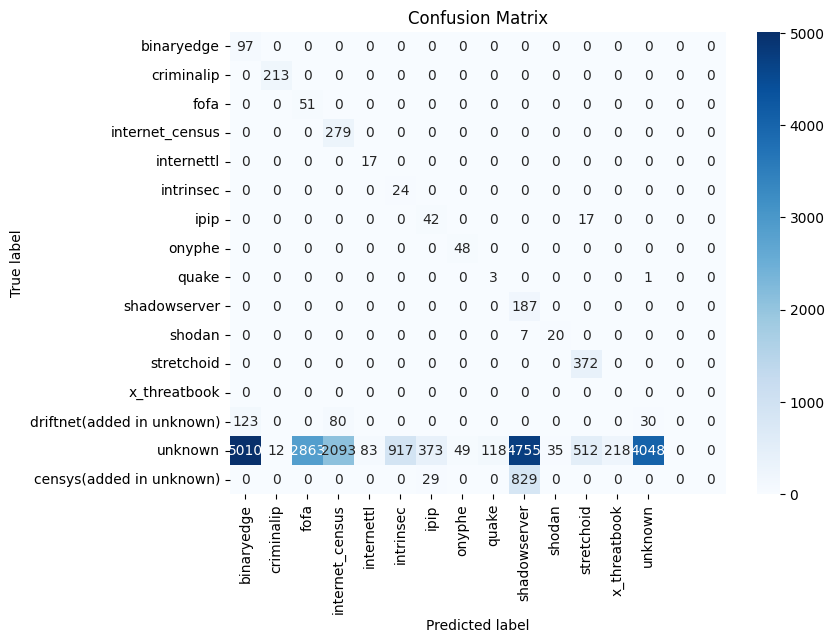

http f1_score_test 0.48632683251769787
       prediction               ip  groundtruth
0               4   96.126.112.135            4
1               4   96.126.112.135            4
2               4   96.126.112.135            4
3               4   165.227.11.236            4
4               4   165.227.11.236            4
...           ...              ...          ...
23550          18  104.234.115.110           26
23551          18  220.158.234.157           26
23552           4   137.74.246.152           26
23553           4   137.74.246.152           26
23554           4   137.74.246.152           26

[23555 rows x 3 columns]
dict_keys(['proj', 'packet_pred', 'y_true', 'ip'])
rm data/selfdeploy_24_25_fulldata_2weektest_tls_openset/labeled_idx/*
256
dataset_name selfdeploy_24_25_2week
data_dir data/cifar10


rm: cannot remove 'data/selfdeploy_24_25_fulldata_2weektest_tls_openset/labeled_idx/*': No such file or directory


num_labels 2500 num_classes 25 this mode use all samples
dataset_data (8681, 26, 26, 3)
dataset_data (52956, 26, 26, 3)


/tmp/ipykernel_1288075/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 2674
dataset_data (2674, 26, 26, 3)
dataset_data (16296, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f8b00ca9fa0> lb_dset 8681
./saved_models/openset_cv/iomatch_selfdeploy_24_25_fulldata_2weektest_tls_extra_ep250_bs32/latest_model.pth
Model at step latest loaded!


  8%|███▍                                        | 5/64 [00:00<00:02, 21.31it/s]

y 256 tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
p tensor([5.9811e-05, 5.7825e-05, 5.6063e-05, 5.8824e-05, 9.8725e-01, 2.8173e-04,
        5.9403e-05, 9.8721e-05, 1.0582e-04, 3.8501e-03,

 20%|████████▋                                  | 13/64 [00:00<00:01, 30.22it/s]

p tensor([7.5650e-06, 7.2288e-06, 7.3506e-06, 7.3307e-06, 6.4110e-02, 2.7569e-05,
        7.2618e-06, 5.4941e-06, 3.2038e-05, 3.7747e-05, 6.4767e-06, 9.7706e-06,
        7.4998e-06, 1.8555e-05, 7.4660e-06, 7.0540e-06, 7.1541e-06, 7.6589e-06,
        2.0589e-04, 5.7913e-06, 9.3542e-01, 6.5806e-06, 7.1216e-06, 1.7125e-05,
        1.4249e-05], device='cuda:0') o_pos tensor([0.0263, 0.0263, 0.0264, 0.0263, 0.0583, 0.0167, 0.0263, 0.0091, 0.0152,
        0.0240, 0.0152, 0.0137, 0.0263, 0.0135, 0.0262, 0.0187, 0.0263, 0.0263,
        0.0203, 0.0174, 0.9399, 0.0117, 0.0263, 0.0083, 0.0237],
       device='cuda:0')
q.data tensor([[5.0416e-06, 5.0750e-06, 4.9352e-06, 5.1212e-06, 2.7354e-03, 2.3571e-05,
         5.0311e-06, 1.7492e-05, 5.2805e-05, 1.3214e-05, 5.6207e-06, 1.9567e-05,
         5.0678e-06, 1.3817e-04, 5.1574e-06, 7.1428e-06, 5.1087e-06, 5.0339e-06,
         1.9955e-04, 1.1821e-05, 8.7640e-01, 4.5921e-06, 5.0708e-06, 9.2569e-06,
         1.1224e-05, 1.2030e-01],
        [1.3819e-04,

 33%|██████████████                             | 21/64 [00:00<00:01, 33.81it/s]

tensor([[6.0571e-07, 6.0694e-07, 5.8972e-07, 6.1663e-07, 4.0703e-04, 3.5475e-06,
         6.0415e-07, 1.6026e-06, 7.6904e-06, 1.2326e-06, 8.5292e-07, 2.1126e-06,
         6.0263e-07, 3.7932e-05, 6.2526e-07, 1.0348e-06, 6.1008e-07, 6.0157e-07,
         4.3180e-05, 1.7075e-06, 9.5948e-01, 5.4207e-07, 6.0655e-07, 8.9915e-07,
         1.2450e-06, 4.0008e-02],
        [2.0162e-05, 2.0270e-05, 1.9864e-05, 2.0577e-05, 5.2556e-03, 7.4725e-05,
         2.0470e-05, 4.4694e-05, 1.6689e-04, 4.3182e-05, 2.5381e-05, 5.3248e-05,
         2.0167e-05, 1.2896e-03, 2.0699e-05, 3.0850e-05, 2.0571e-05, 2.0410e-05,
         4.1394e-04, 5.1249e-05, 8.2961e-01, 1.2239e-05, 2.0237e-05, 3.9987e-05,
         2.7650e-05, 1.6266e-01],
        [3.7245e-05, 3.6857e-05, 3.6822e-05, 3.6604e-05, 2.8392e-04, 1.0480e-04,
         3.7825e-05, 6.6030e-05, 1.5116e-04, 4.8482e-05, 4.8626e-05, 8.5762e-05,
         3.6702e-05, 1.5605e-04, 3.7073e-05, 3.8678e-05, 3.6709e-05, 3.7406e-05,
         2.2935e-02, 5.7176e-05, 7.3182e-

 45%|███████████████████▍                       | 29/64 [00:00<00:00, 35.25it/s]

y 256 tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26

 52%|██████████████████████▏                    | 33/64 [00:01<00:00, 35.75it/s]

tensor([1.6106e-02, 1.6118e-02, 1.6115e-02, 1.6124e-02, 4.2489e-03, 1.6726e-02,
        1.6104e-02, 9.8882e-01, 1.7687e-03, 1.1925e-02, 3.7420e-03, 1.2460e-02,
        1.6104e-02, 3.3696e-03, 1.6101e-02, 6.5241e-03, 1.6100e-02, 1.6117e-02,
        1.1221e-02, 9.6300e-05, 2.7538e-03, 1.1220e-03, 1.6078e-02, 1.0825e-03,
        1.8677e-02], device='cuda:0')
q.data tensor([[8.6760e-07, 8.5862e-07, 8.5529e-07, 8.4059e-07, 6.7626e-06, 7.3000e-06,
         8.6407e-07, 9.7140e-01, 2.4348e-06, 6.8944e-06, 2.5812e-06, 1.5854e-04,
         8.0931e-07, 5.9570e-06, 8.3914e-07, 2.5803e-06, 8.4954e-07, 8.3690e-07,
         2.5782e-06, 8.6835e-08, 2.6423e-06, 1.6820e-06, 8.4398e-07, 1.2688e-06,
         3.8566e-04, 2.8001e-02],
        [6.7664e-07, 6.5699e-07, 6.6049e-07, 6.4580e-07, 7.9799e-06, 2.5325e-06,
         6.7008e-07, 9.7393e-01, 5.6919e-07, 8.1525e-06, 2.5572e-06, 9.2464e-05,
         6.2621e-07, 6.0635e-06, 6.3913e-07, 5.1269e-06, 6.5741e-07, 6.4776e-07,
         2.1300e-06, 4.7722e-08, 1

 64%|███████████████████████████▌               | 41/64 [00:01<00:00, 34.02it/s]

tensor([[8.7126e-07, 8.4322e-07, 8.5974e-07, 8.8255e-07, 6.2383e-06, 9.1739e-06,
         8.7397e-07, 2.5064e-07, 1.0398e-06, 1.0729e-06, 1.0526e-06, 3.3223e-07,
         8.4523e-07, 1.9170e-06, 8.6336e-07, 1.7432e-06, 8.2993e-07, 8.7749e-07,
         3.8357e-02, 5.0990e-07, 6.4391e-01, 1.7645e-06, 8.4331e-07, 1.0457e-06,
         2.4914e-06, 3.1769e-01],
        [2.9595e-07, 2.9420e-07, 2.7715e-07, 2.9101e-07, 9.3628e-06, 2.0930e-06,
         2.8913e-07, 8.1510e-01, 1.3069e-07, 6.4330e-07, 6.1801e-09, 7.0705e-03,
         2.9746e-07, 1.6078e-08, 2.9273e-07, 8.9805e-08, 2.9357e-07, 2.8545e-07,
         5.6130e-08, 2.4993e-09, 8.0655e-08, 3.6732e-08, 2.9119e-07, 5.8667e-08,
         3.2272e-05, 1.7779e-01],
        [8.4720e-07, 8.5793e-07, 8.7281e-07, 8.7235e-07, 2.5453e-03, 4.5522e-07,
         8.9394e-07, 1.4318e-08, 1.2813e-05, 2.1627e-06, 5.6044e-06, 4.0122e-08,
         8.1779e-07, 6.2310e-07, 9.2930e-07, 6.5149e-07, 8.3882e-07, 8.8160e-07,
         4.4719e-06, 1.0565e-04, 7.5781e-

 77%|████████████████████████████████▉          | 49/64 [00:01<00:00, 31.95it/s]

tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 

 83%|███████████████████████████████████▌       | 53/64 [00:01<00:00, 31.67it/s]

p tensor([1.5369e-05, 1.4556e-05, 1.5733e-05, 1.5878e-05, 2.6918e-04, 6.3177e-05,
        1.5805e-05, 1.3605e-05, 1.8983e-04, 2.1691e-05, 1.6600e-05, 1.7711e-05,
        1.5351e-05, 1.0122e-04, 1.5823e-05, 1.4142e-05, 1.5224e-05, 1.6251e-05,
        1.2751e-01, 1.6745e-05, 8.7153e-01, 1.6353e-05, 1.5390e-05, 2.9413e-05,
        2.8281e-05], device='cuda:0') o_pos tensor([0.1044, 0.1045, 0.1044, 0.1042, 0.0484, 0.0636, 0.1044, 0.0714, 0.0836,
        0.0870, 0.0842, 0.0574, 0.1037, 0.0684, 0.1045, 0.0548, 0.1036, 0.1042,
        0.1500, 0.0850, 0.8643, 0.0885, 0.1043, 0.0640, 0.0695],
       device='cuda:0')
q.data tensor([[3.6648e-05, 3.6338e-05, 3.6189e-05, 3.6184e-05, 2.9158e-04, 9.3865e-05,
         3.7205e-05, 6.7911e-05, 1.8093e-04, 4.7697e-05, 4.5646e-05, 8.9486e-05,
         3.6181e-05, 1.5163e-04, 3.6544e-05, 3.4821e-05, 3.6219e-05, 3.6818e-05,
         1.9701e-02, 5.4536e-05, 7.5481e-01, 5.0834e-05, 3.6805e-05, 5.1705e-05,
         6.3202e-05, 2.2390e-01],
        [1.0346e-04,

 95%|████████████████████████████████████████▉  | 61/64 [00:01<00:00, 31.04it/s]

tensor([[4.7873e-07, 5.0331e-07, 4.5516e-07, 4.9849e-07, 1.5340e-06, 3.6853e-07,
         4.6748e-07, 9.7909e-01, 4.9368e-08, 4.3087e-07, 1.0875e-07, 6.3572e-05,
         4.8254e-07, 2.6581e-07, 4.9471e-07, 3.9040e-07, 4.8678e-07, 4.7640e-07,
         4.3214e-07, 9.8742e-10, 6.7755e-08, 9.9251e-08, 4.6652e-07, 1.0857e-07,
         7.8112e-05, 2.0759e-02],
        [6.3605e-07, 7.1696e-07, 6.5734e-07, 7.3264e-07, 6.2943e-06, 1.4207e-08,
         6.5676e-07, 9.6606e-01, 7.6264e-08, 7.3930e-07, 1.3959e-05, 2.0531e-08,
         6.9494e-07, 6.5895e-07, 6.7429e-07, 7.2376e-06, 7.0266e-07, 7.2506e-07,
         4.3141e-06, 9.1012e-11, 1.1124e-08, 3.8328e-07, 6.1834e-07, 1.6127e-05,
         5.0991e-04, 3.3378e-02],
        [6.9827e-08, 7.0264e-08, 6.4779e-08, 6.8627e-08, 1.0236e-07, 4.5341e-07,
         6.7643e-08, 9.8224e-01, 1.1242e-08, 6.3536e-08, 5.5829e-09, 6.3782e-05,
         6.9022e-08, 1.2591e-08, 6.8907e-08, 2.6840e-08, 6.9995e-08, 6.7044e-08,
         1.7681e-08, 8.7529e-11, 4.1885e-

100%|███████████████████████████████████████████| 64/64 [00:02<00:00, 30.20it/s]


tensor([ 7,  4, 25,  5, 20, 25,  7,  5, 20,  7, 20,  7,  7, 21, 20, 21,  7,  4,
         4, 11, 20, 15,  4, 11, 25,  5, 19, 20,  7,  7, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  7, 20,  5, 25, 11,  5,
        19,  7,  7,  8,  7, 20,  7,  7, 11, 19, 20,  5,  5,  4, 20, 25,  8, 13,
         7,  4, 20, 19, 21, 21,  7,  7, 11,  7,  4,  9,  4, 20,  7, 20,  5, 20,
         7,  7,  4, 25,  7,  7,  9, 21,  9,  4, 21,  7,  4,  7,  7, 20, 20,  7,
         4, 20,  7,  7,  5,  5, 20, 25,  5, 25,  4,  4,  4,  4, 20,  5,  4,  5,
         7, 15,  9, 21,  4,  5,  9,  7, 15,  9, 21,  4,  5,  5,  9, 20,  7,  7,
         5,  7,  7,  7,  5, 20,  5, 11, 19,  4,  7,  7,  7,  5,  7, 23, 23,  4,
         4,  7, 21,  7,  7, 25,  7, 25,  5,  7,  7,  5,  4,  4,  4, 20, 19,  5,
         5,  4, 11, 20, 19,  7,  7,  7,  5, 20,  4,  5, 19, 11,  7,  4,  4,  4,
         4,  4,  4,  4,  4,  5, 15,  7,  7, 20, 20, 20, 20, 20, 20, 25, 19, 11,
         5,  4, 20, 25, 20,  7, 20, 20, 

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


o_acc_f_q_filtered 0.6710320476370238
o_acc_f_q_filtered_masked 0.6915473339932535
fscore 0.06611691629972008 f_hq 0.06585356554620213
#############################################################
 Closed Accuracy on Closed Test Data (p / hp): 90.28 / 90.35
 Open Accuracy on Full Test Data (q / hq):     63.16 / 63.02
 Open Accuracy on Extended Test Data (q / hq): 0.00 / 0.00
#############################################################



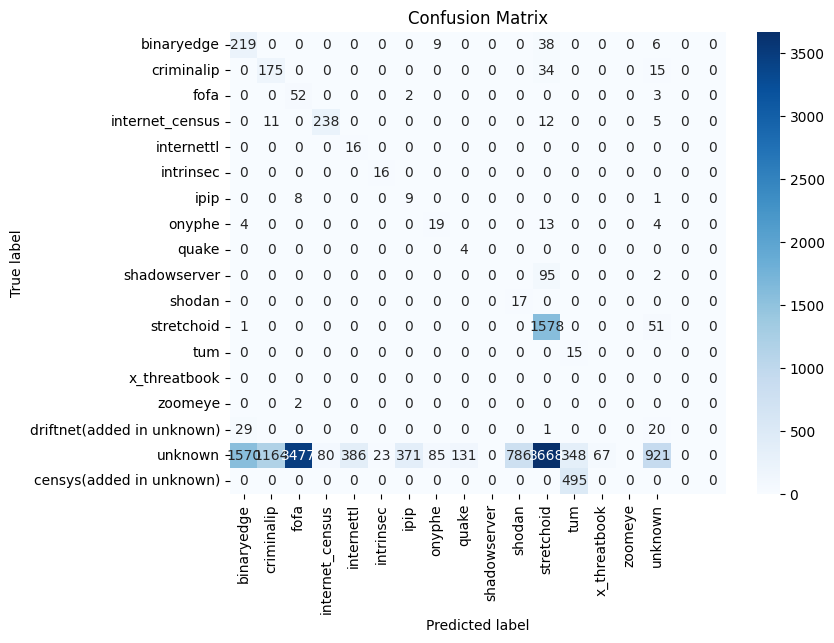

tls f1_score_test 0.7308416616152641
       prediction               ip  groundtruth
0               4  104.237.145.207            4
1               4   104.237.145.35            4
2               4    96.126.112.60            4
3               4    45.79.210.137            4
4               4   74.207.240.227            4
...           ...              ...          ...
16291           7   196.251.71.111           26
16292          20   137.74.246.152           26
16293           7    95.214.53.106           26
16294           7      36.156.22.4           24
16295           7      36.156.22.4           24

[16296 rows x 3 columns]
dict_keys(['proj', 'packet_pred', 'y_true', 'ip'])
rm data/selfdeploy_24_25_fulldata_2weektest_dns_openset/labeled_idx/*
256
dataset_name selfdeploy_24_25_2week
data_dir data/cifar10


rm: cannot remove 'data/selfdeploy_24_25_fulldata_2weektest_dns_openset/labeled_idx/*': No such file or directory
/tmp/ipykernel_1288075/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t

num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1127, 16, 16, 3)
dataset_data (20354, 16, 16, 3)
len_seen_indices 327
dataset_data (327, 16, 16, 3)
dataset_data (5291, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7f8a0ad25040> lb_dset 1127
./saved_models/openset_cv/iomatch_selfdeploy_24_25_fulldata_2weektest_dns_extra_ep250_bs32/latest_model.pth
Model at step latest loaded!


 24%|██████████▍                                 | 5/21 [00:00<00:00, 20.15it/s]

y 256 tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 13, 13, 13, 13, 16, 16, 16, 16,
        16, 18, 18, 18, 18, 18, 18

 67%|████████████████████████████▋              | 14/21 [00:00<00:00, 31.95it/s]

tensor([25, 25, 25, 16, 25, 25, 25,  9,  9,  9,  9,  9, 25,  9,  9,  9, 16,  9,
        25,  9,  9,  9, 25,  9,  9,  9, 25, 25, 25, 25, 25, 25, 25,  9, 25,  9,
         9,  9,  9,  9, 25, 25, 25, 25, 16,  9,  9,  9, 25, 25,  9, 25, 25,  9,
        25,  9, 25, 25,  9, 25,  4, 25,  9, 25, 16, 16, 25, 25, 25, 25, 16, 25,
        25, 25, 25, 25, 25, 25,  9, 25,  9,  9, 25, 25,  9,  9,  9,  9,  9,  9,
         9,  9, 25,  9, 25, 25, 25, 25,  9,  9, 25,  9,  9,  9,  9, 16,  9,  9,
         9,  9, 25, 25, 25, 25, 25, 25,  9,  9, 25,  9,  9,  9, 25,  9, 25, 25,
         9,  9,  4, 25,  9,  9,  9,  9,  9,  9,  9,  9,  4,  4,  9,  9, 25, 25,
         9,  9,  9, 25, 25,  9,  9,  9,  9,  9,  4,  9,  4, 25, 25,  9, 25, 25,
         4, 25, 25, 25, 25, 25,  4,  9, 25, 25, 25, 25, 25, 25, 25,  9,  9, 25,
         9,  9,  9,  9,  9,  9, 25, 25,  9,  9, 25, 25, 25,  4, 25, 25,  4, 16,
        25, 16,  4, 16, 25, 25,  4, 25, 25,  4,  9,  9,  9,  9, 25,  9,  9, 25,
         4,  9,  9,  9,  9,  9, 25, 25, 

 86%|████████████████████████████████████▊      | 18/21 [00:00<00:00, 34.39it/s]

tensor([[5.6074e-05, 5.6147e-05, 5.3768e-05, 5.3653e-05, 4.2573e-01, 9.8086e-04,
         1.0747e-04, 5.5890e-05, 9.2542e-02, 7.6635e-06, 4.9658e-05, 5.5342e-05,
         5.6817e-05, 4.8333e-04, 5.4998e-05, 5.5946e-05, 2.8946e-06, 5.1536e-05,
         7.7799e-05, 5.9588e-06, 2.0829e-03, 5.1152e-05, 5.3650e-05, 5.5158e-05,
         5.2813e-05, 4.7717e-01],
        [5.6074e-05, 5.6147e-05, 5.3768e-05, 5.3653e-05, 4.2573e-01, 9.8086e-04,
         1.0747e-04, 5.5890e-05, 9.2542e-02, 7.6635e-06, 4.9658e-05, 5.5342e-05,
         5.6817e-05, 4.8333e-04, 5.4998e-05, 5.5946e-05, 2.8946e-06, 5.1536e-05,
         7.7799e-05, 5.9588e-06, 2.0829e-03, 5.1152e-05, 5.3650e-05, 5.5158e-05,
         5.2813e-05, 4.7717e-01],
        [9.9354e-06, 9.8264e-06, 1.0407e-05, 1.0269e-05, 8.7549e-06, 9.3516e-02,
         6.2932e-06, 1.0371e-05, 2.2148e-01, 5.0491e-06, 9.9156e-06, 9.9372e-06,
         1.0165e-05, 1.9130e-02, 1.0600e-05, 1.0072e-05, 4.1284e-06, 1.0124e-05,
         4.0275e-06, 7.3052e-06, 1.8675e-

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 27.75it/s]


y_true[closed_mask] [ 4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  6  6
  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 13 13 13 13
 16 16 16 16 16 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 

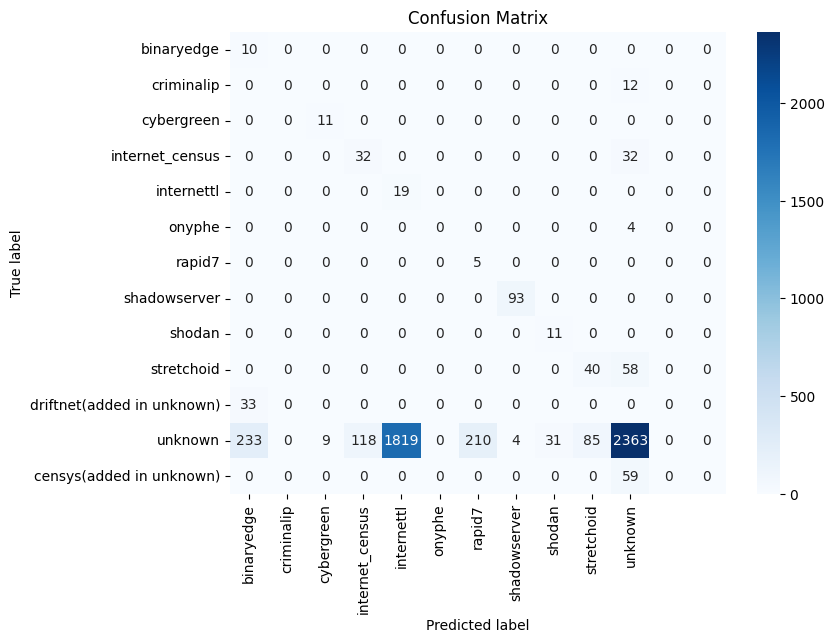

dns f1_score_test 0.6789811238935856
      prediction              ip  groundtruth
0              4  167.99.227.103            4
1              4   50.116.53.243            4
2              4   45.79.151.251            4
3              4    45.79.71.182            4
4              4    45.33.84.149            4
...          ...             ...          ...
5286           9    193.200.78.3           26
5287           9   87.121.84.143           26
5288          25  198.235.24.140           26
5289           9    193.200.78.3           26
5290           9   87.121.84.143           26

[5291 rows x 3 columns]
dict_keys(['proj', 'packet_pred', 'y_true', 'ip'])


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report


dataset_name='SelfDeploy25'
if(dataset_name=='SelfDeploy24'):
    dataset='selfdeploy_merge_month_2_4_2weektest'
    name='merge_month_2_4_2week'
if(dataset_name=='SelfDeploy25'):
    dataset='selfdeploy_24_25_fulldata_2weektest'
    name='selfdeploy_24_25_2week'

for protocol in ['http','tls','dns']:#
    
    cmd1='rm data/'+dataset+'_'+protocol+'_openset/labeled_idx/*'
    print(cmd1)
    r1=os.system(cmd1)
    print(r1)    
    config_name='iomatch_exp_'+dataset+'_'+protocol+'.yaml'
    args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/'+config_name])#test5#iomatch_cifar10_150_eval_25_n#iomatch_cifar10_14000_15class_comp_1
    over_write_args_from_file(args, args.c)#iomatch_cifar10_300_13_2class_comp_1#iomatch_cifar10_14000_13_2class_comp_1
    args.data_dir = 'data'
    total_epoch=250
    current_epoch=20
    batch_size=64
    
    results = np.zeros((len(epoch_list), len(batch_size_list)))
    for i,current_epoch in enumerate(epoch_list):
        for j,batch_size in enumerate(batch_size_list):
            args.bsz = batch_size
            args.load_path = "./saved_models/openset_cv/iomatch_"+dataset+"_"+protocol+"_extra_ep"+str(total_epoch)+"_bs"+str(batch_size)+"/latest_model.pth"
            dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=False)
            best_net = load_model_at('latest')#latest
            eval_dict = evaluate_io(args, best_net, dataset_dict)
            
        
            
            label_list=eval_dict['label_list']

            labels=label_list
            
            labels_x=label_list[:-3]+['unknown']
            

            plt.figure(figsize=(8, 6))
            sns.heatmap(eval_dict['o_cfmat_f_q'], annot=True, cmap='Blues', fmt='g',xticklabels=labels_x,yticklabels=labels)#, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']
            plt.xlabel('Predicted label')
            plt.ylabel('True label')
            plt.title('Confusion Matrix')
            plt.show()
            

            value_to_delete = 26
            
            
            mask = eval_dict['y_true'] != value_to_delete
            filtered_y_true = eval_dict['y_true'][mask]
            filtered_pred_q = eval_dict['pred_q'][mask]
            filtered_y_true[filtered_y_true >25]=25
            
            #report=classification_report(filtered_y_true,filtered_pred_q,target_names=label_list[:-3]+['driftnet+censys(added in unknown)'])
            #print(report)
            f1_score_test=f1_score(filtered_y_true,filtered_pred_q,average='weighted')
            print(protocol,'f1_score_test',f1_score_test)
            results[i, j] = f1_score_test

    
            import numpy as np
            import pandas as pd
            import pickle
            
            
            if('http' in config_name):
                proto='http'
            if('tls' in config_name):
                proto='tls'
            if('dns' in config_name):
                proto='dns'
            if('ssh' in config_name):
                proto='ssh'
            if('rdp' in config_name):
                proto='rdp'
                
            #name=dataset
            
            mode='test'
            npy_path1 = '../dataset/npy/ip_array_'+proto+'_'+name+'_'+mode+'.npy'
           #npy_path2 = 'label_array_'+proto+'_'+name+'_'+mode+'.npy'
            #dataset = NumpyDataset(npy_path1,npy_path2)
            
            loaded_array = np.load(npy_path1,allow_pickle=True)
            loaded_array
            len(loaded_array)
        
            mask = ~np.isin(loaded_array, ['192.168.1.0', '192.168.2.0','192.168.3.0','192.168.4.0','192.168.5.0'])
            loaded_array = loaded_array[mask]
            
            pred = eval_dict['pred_q']
            pred = pred[mask]
            
            y_true = eval_dict['y_true']
            y_true = y_true[mask]
            
            df = pd.DataFrame({'prediction': pred, 'ip': loaded_array,'groundtruth':y_true})
            
            print(df)
        
           
        
            df.to_csv('result_'+proto+'_'+name+'_'+mode+'.csv', index=False)


            
            test_dns_label_dic = {}

            for value, group_df in df.groupby('ip'):
                test_dns_label_dic[value] = group_df
                
            test_dns_label_dic_common={}
            for i in test_dns_label_dic.keys():
                test_dns_label_dic_common[i]=test_dns_label_dic[i]['prediction'].mode().values[0]
            
            def protocol_level_prediciton(ip_train2,y_train2,train2_label_dic_common):
                a=pd.DataFrame()
                a['ip']=ip_train2
                a['label']=y_train2
                a['pred_label']=None
                a=a.drop_duplicates()
                for index, row in a.iterrows():
                    a.loc[index,'pred_label']=train2_label_dic_common[row['ip']]
                #print(a)
                return a
            df_ip_dns_test=protocol_level_prediciton(loaded_array,y_true,test_dns_label_dic_common)
            df_ip_dns_test=df_ip_dns_test.rename(columns={'pred_label':'pred_label_'+proto})
        
            feat_proj=eval_dict['feat_proj']

                        
            dic_proj={}
            dic_proj['proj']=feat_proj
            
            pred = eval_dict['pred_q']
            y_true = eval_dict['y_true']
            
            dic_proj['packet_pred']=pred
            dic_proj['y_true']=y_true
            
            loaded_array = np.load(npy_path1,allow_pickle=True)
            dic_proj['ip']=loaded_array
            
            print(dic_proj.keys())

            with open('packet_level_proj_'+proto+'_'+name+'_'+mode+'.pkl', 'wb') as f:
                pickle.dump(dic_proj, f)